In [1]:
# Don't change this cell; just run it.
import numpy as np
import pandas as pd
from bootstrap_plots import *
from IPython.display import display, Markdown

# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt

# Make the plots look more fancy.
plt.style.use('fivethirtyeight')

> This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).


# The Fundamental Problem of Data Science

Data science can be (very) roughly defined as the implementation of statistical
analysis in code and algorithms.

We could also very (roughlt) define data science as the science of drawing insights from data, 
using code, under uncertainty.

This uncertainty results from what I'll call "The Fundamental Problem" of data science:

> *What we care about are populations, but all we (usually!) have access to are samples.*

More spcecifically: we care about populations and parameters but all we have access to are samples and statistics.

* Population - all the things (people, cars, rivers, planets) that we could measure a variable of interest for

* Sample - a subset of a population

The problem we face with samples - even if they are randomly collected - is *sampling error*.

One of the beautiful things about code is the ability to simulate data to vividly illustrate
statistical principles.

The code cell below creates some data for a hypothetical population:

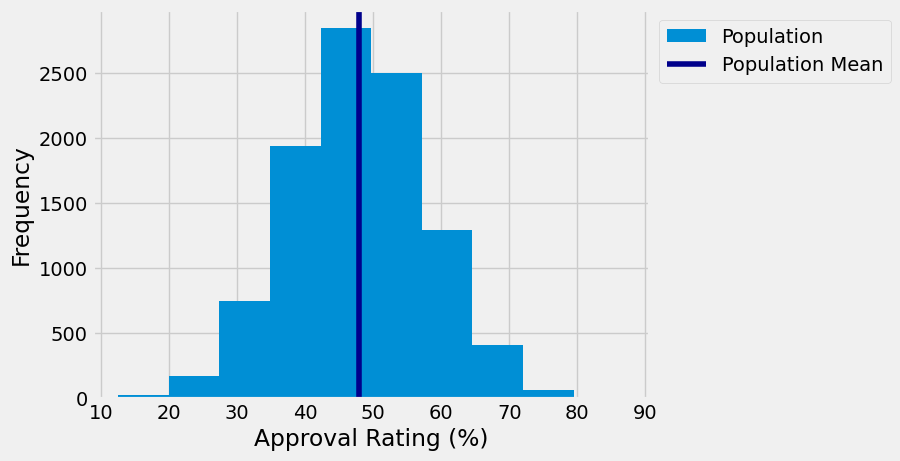

In [2]:
# create some illutrative population data
population = population_plot(population_size = 10000)

Truly random samples are the gold dust of empirical research, as they are
on average likely to represent underlying populations.

However, a random sample is unlikely to *perfectly* capture the population parameter.

It is like to be somewhat "off" from the true population parameter.

The code cell below randomly draws a sample from the population we created just now,
and shows it alongside the population data:

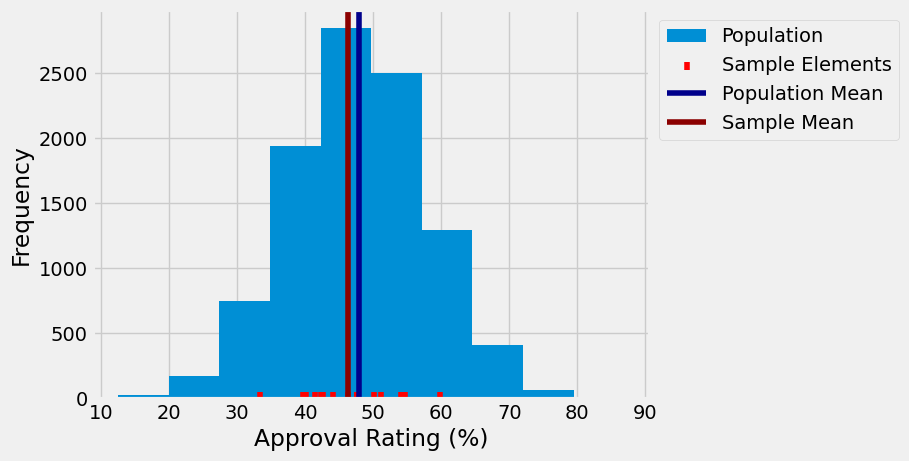

In [3]:
# draw a random sample from the population data
population_plot_with_sample(population, sample_size = 15)

However, even if our sample is perfectly random, some proportion of the time
we are going to end up with samples that badly estimate the population parameter:

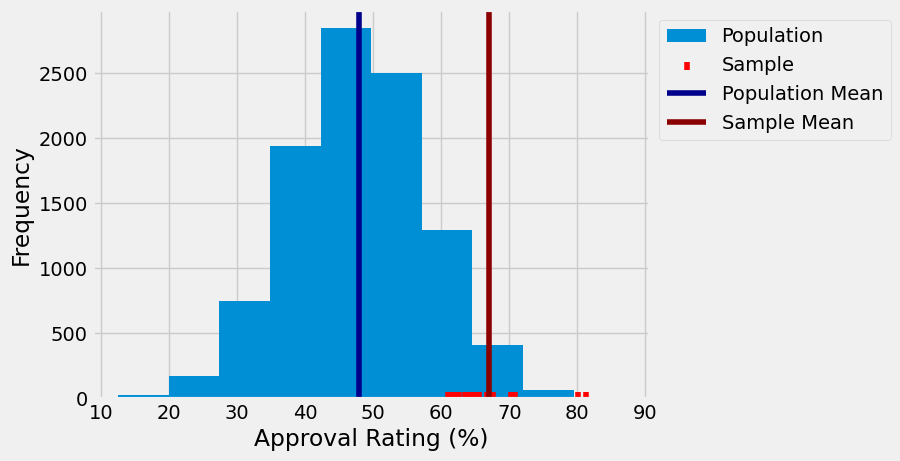

In [4]:
# draw an unrepresentative sample from the data
population_plot_with_unrepresentative_sample(population, sample_size = 15)

### A typical research situation

A data scientist is using the data in a random sample to estimate an unknown
parameter. She uses the sample to calculate the value of a statistic that she
will use as her estimate.

Once she has calculated the observed value of her statistic, she could just
present it as her estimate and go on her merry way. But she's a data scientist.
She knows that her random sample is just one of numerous possible random
samples, and thus her estimate is just one of numerous plausible estimates.

By how much could those estimates vary? To answer this, it appears as though
she needs to draw another sample from the population, and compute a new
estimate based on the new sample. But she doesn't have the resources to go back
to the population and draw another sample.

It looks as though the data scientist is stuck.

What she needs is a guide to how uncertain her estimate is, something to help her be least wrong, most of the time.

# The Bootstrap

Fortunately, a brilliant idea called *the bootstrap* can help her out. Since it
is not feasible to generate new samples from the population, the bootstrap
generates new random samples by a method called *resampling*: the new samples
are drawn at random *from the original sample*.

In this section, we will see how and why the bootstrap works. In the rest of
the chapter, we will use the bootstrap for inference.

## Employee Compensation in the City of San Francisco

We're going to use a real dataset now which puts us in the rare situation of
being able to view a entire population of data.

[SF OpenData](https://data.sfgov.org) is a website where the City and County of
San Francisco make some of their data publicly available. One of the data sets
contains compensation data for employees of the City. These include medical
professionals at City-run hospitals, police officers, fire fighters,
transportation workers, elected officials, and all other employees of the City.

Compensation data for the calendar year 2015 are in the table `sf2015`.

In [5]:
# load in the data
sf2015 = pd.read_csv('san_francisco_2015.csv')

# show the first few rows
sf2015.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",...,21538,82146.04,0.00,0.00,82146.04,16942.21,12340.88,6337.73,35620.82,117766.86
1,Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12.0,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,...,5459,32165.75,973.19,848.96,33987.90,0.00,4587.51,2634.42,7221.93,41209.83
2,Calendar,2015,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",...,41541,71311.00,5757.98,0.00,77068.98,14697.59,12424.50,6370.06,33492.15,110561.13
3,Calendar,2015,4,Community Health,DPH,Public Health,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,26718,28430.25,0.00,763.07,29193.32,0.00,4223.14,5208.51,9431.65,38624.97
4,Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,790.0,"SEIU - Miscellaneous, Local 1021",8200,Protection & Apprehension,...,45810,7948.75,0.00,0.00,7948.75,0.00,2873.17,616.24,3489.41,11438.16


In [6]:
# show the columns that the data contains
list(sf2015.columns)

['Year Type',
 'Year',
 'Organization Group Code',
 'Organization Group',
 'Department Code',
 'Department',
 'Union Code',
 'Union',
 'Job Family Code',
 'Job Family',
 'Job Code',
 'Job',
 'Employee Identifier',
 'Salaries',
 'Overtime',
 'Other Salaries',
 'Total Salary',
 'Retirement',
 'Health/Dental',
 'Other Benefits',
 'Total Benefits',
 'Total Compensation']

There is one row for each of 42,979 employees. There are numerous columns
containing information about City departmental affiliation and details of the
different parts of the employee's compensation package. Here is the row
corresponding to the late [Mayor Ed
Lee](https://en.wikipedia.org/wiki/Ed_Lee_(politician))

In [7]:
# get the row(s) corresponding to a specific job role
sf2015[sf2015['Job'] == 'Mayor']

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
3335,Calendar,2015,6,General Administration & Finance,MYR,Mayor,556.0,Elected Officials,1100,Administrative & Mgmt (Unrep),...,22433,288963.55,0.0,0.0,288963.55,58117.03,12424.5,20292.95,90834.48,379798.03


We are going to study the final column, `Total Compensation`. That's the
employee's salary plus the City's contribution towards his/her retirement and
benefit plans.

Financial packages in a calendar year can sometimes be hard to understand as
they depend on the date of hire, whether the employee is changing jobs within
the City, and so on. For example, the lowest values in the `Total Compensation`
column look a little strange.

In [8]:
# sort the data by Total Compensation, and show the first 10 rows
sf2015.sort_values('Total Compensation').head(10)

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
27308,Calendar,2015,1,Public Protection,FIR,Fire Department,798.0,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,...,43833,0.0,0.0,0.00,0.00,0.0,0.00,-423.76,-423.76,-423.76
15746,Calendar,2015,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,...,27871,-292.4,0.0,0.00,-292.40,0.0,-95.58,-22.63,-118.21,-410.61
24576,Calendar,2015,1,Public Protection,JUV,Juvenile Probation,790.0,"SEIU - Miscellaneous, Local 1021",8300,Correction & Detention,...,10517,0.0,0.0,0.00,0.00,0.0,0.00,-159.12,-159.12,-159.12
42982,Calendar,2015,6,General Administration & Finance,CPC,City Planning,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,...,18961,0.0,0.0,0.00,0.00,0.0,0.00,-26.53,-26.53,-26.53
23310,Calendar,2015,6,General Administration & Finance,CPC,City Planning,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,...,19387,0.0,0.0,0.00,0.00,0.0,0.00,-9.51,-9.51,-9.51
27855,Calendar,2015,2,"Public Works, Transportation & Commerce",PUC,PUC Public Utilities Commission,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,...,28988,0.0,0.0,0.00,0.00,0.0,0.00,-3.10,-3.10,-3.10
17663,Calendar,2015,1,Public Protection,JUV,Juvenile Probation,39.0,"Stationary Engineers, Local 39",7300,Journeyman Trade,...,19125,0.0,0.0,0.00,0.00,0.0,0.00,-0.01,-0.01,-0.01
34350,Calendar,2015,1,Public Protection,ECD,Department of Emergency Management,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,30025,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00
40184,Calendar,2015,7,General City Responsibilities,UNA,General Fund Unallocated,790.0,"SEIU - Miscellaneous, Local 1021",3200,Recreation,...,49784,0.0,0.0,0.00,0.00,0.0,0.00,1.27,1.27,1.27
16641,Calendar,2015,4,Community Health,DPH,Public Health,250.0,"SEIU - Health Workers, Local 1021",2600,Dietary & Food,...,26768,0.0,0.0,2.21,2.21,0.0,0.00,0.17,0.17,2.38


For clarity of comparison, we will focus our attention on those who had at
least the equivalent of a half-time job for the whole year. At a minimum wage
of about \\\$10 per hour, and 20 hours per week for 52 weeks, that's a salary of
about \\\$10,000.

In [9]:
# trim the dataframe to employees earning over $10,000 per year
sf2015 = sf2015[sf2015['Salaries'] > 10000]

# show the first few rows of the trimmed data
sf2015.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
0,Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21.0,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",...,21538,82146.04,0.00,0.00,82146.04,16942.21,12340.88,6337.73,35620.82,117766.86
1,Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12.0,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,...,5459,32165.75,973.19,848.96,33987.90,0.00,4587.51,2634.42,7221.93,41209.83
2,Calendar,2015,4,Community Health,DPH,Public Health,790.0,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",...,41541,71311.00,5757.98,0.00,77068.98,14697.59,12424.50,6370.06,33492.15,110561.13
3,Calendar,2015,4,Community Health,DPH,Public Health,351.0,Municipal Executive Association - Miscellaneous,0900,Management,...,26718,28430.25,0.00,763.07,29193.32,0.00,4223.14,5208.51,9431.65,38624.97
6,Calendar,2015,4,Community Health,DPH,Public Health,791.0,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,...,7506,187247.00,0.00,11704.06,198951.06,37683.66,12424.50,11221.73,61329.89,260280.95


In [10]:
# show how many employees are in the trimmed data
len(sf2015)

36569

## Population and Parameter

Let this table of just over 36,500 rows be our population. Here is a histogram
of the total compensations.

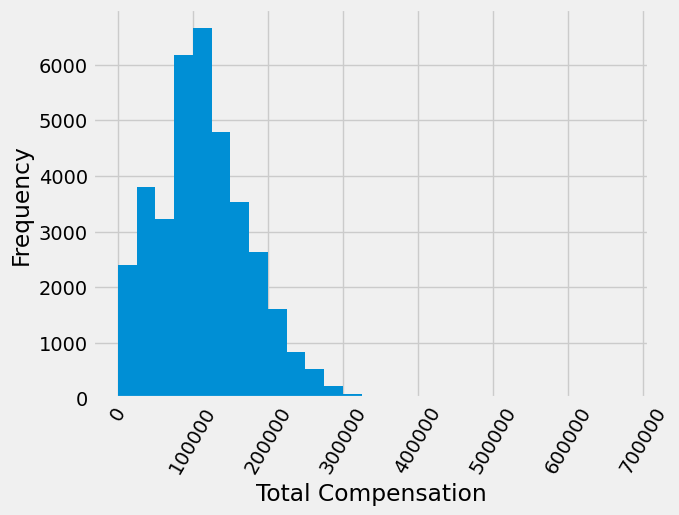

In [11]:
# set the bins for the histogram (this will allow us to see a bit more of the
# complexity of the distribution)
sf_bins = np.arange(0, 700000, 25000)

# plot the histogram
sf2015['Total Compensation'].plot.hist(bins=sf_bins)

# add axis labels
plt.xlabel('Total Compensation')

# rotate the x-axis labels, for clarity
plt.xticks(rotation = 60);

This is fairly typical for an income distribution - a lot of people have a little, a lot of people have some and a very small number of people have a lot...

While most of the values are below \\\$300,000, a few are quite a bit higher. For
example, the total compensation of the Chief Investment Officer was almost
\\\$650,000. That is why the horizontal axis stretches to \\\$700,000.

In [12]:
# show the data by Total Compensation, show highest earners at the top of the dataframe
sf2015.sort_values('Total Compensation', ascending=False)[['Job', 'Total Compensation']].head()

,Job,Total Compensation
19177,Chief Investment Officer,648875.24
13194,Asst Med Examiner,480509.28
499,Asst Med Examiner,427219.28
17805,Dept Head V,426686.07
5171,"Adm, SFGH Medical Center",422799.94


Now let the parameter be the median of the total compensations.

Since we have the luxury of having all of the data from the population, we can
simply calculate the parameter:

In [13]:
# isolate the population compensation values in a pandas Series
compensation = sf2015['Total Compensation']

# calculate the population median
pop_median = np.median(compensation)

# show the population median
print(f"The population median = {pop_median}")

The population median = 110305.79


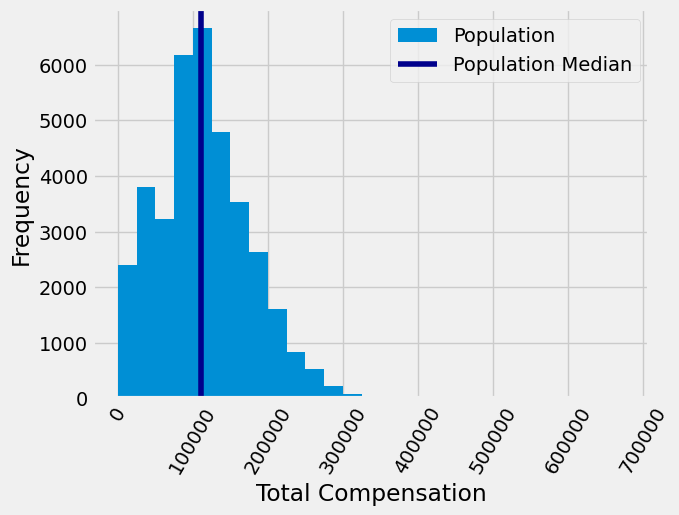

In [14]:
# plot the population data and show the median
population_plot_sf_data(sf2015, bins = sf_bins);

The median total compensation of all employees was just over \$110,300.

From a practical perspective, there is no reason for us to draw a sample to
estimate this parameter since we simply know its value. But in this section we
are going to pretend we don't know the value, and see how well we can estimate
it based on a random sample.

In later sections, we will come down to earth and work in situations where the
parameter is unknown. For now, we are all-knowing.


## A Random Sample and an Estimate

To illustrate the effect of sampling error that we saw earlier us draw a sample of employees
at random without replacement, and let the median total compensation of the sampled employees
serve as our estimate of the parameter.

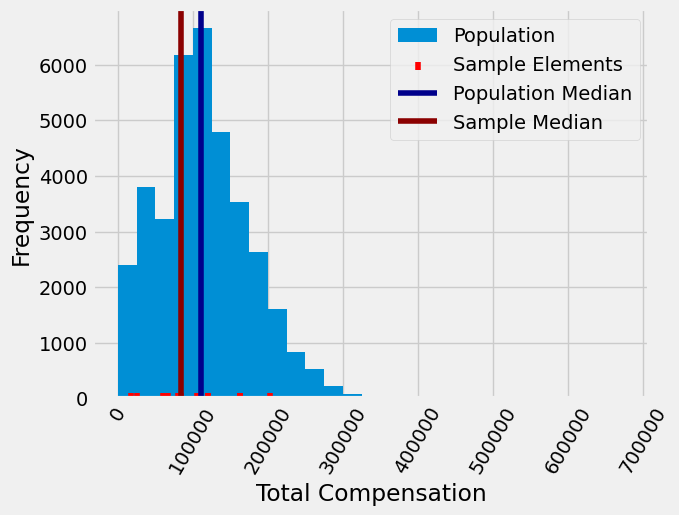

In [15]:
# draw a random sample, without replacement, from the population data
population_plot_sf_data_with_sample(sf2015, bins = sf_bins, sample_size = 15) 

For the rest of the tutorial, we'll use a larger sample of 500 employees to estimate the
population parameter.

Let's have a look at the histogram of a random sample of 500 employees.

Sample Median = 103941

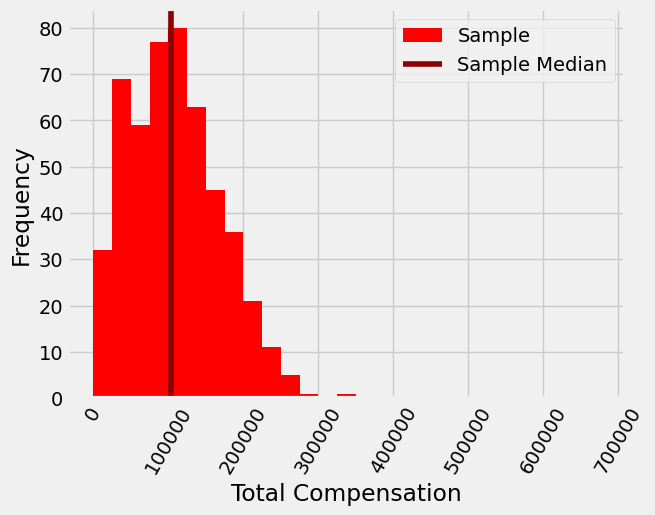

In [16]:
# draw a sample of size 500 from the compensation Series, without replacement.
our_sample = compensation.sample(500, replace=False)

# plot a histogram of the sample
our_sample.plot.hist(bins=sf_bins, color = 'red', label = "Sample")

# show the sample median
plt.axvline(np.median(our_sample), color = 'darkred', label = "Sample Median")

# show the legend, add x-axis labels
add_x_labels_total_compensation();

display(Markdown(f"Sample Median = {round(np.median(our_sample))}"))

In [17]:
# store the sample median as a variable
est_median = np.median(our_sample)
est_median

103940.84

The sample size is large. By the law of averages, the distribution of the
sample resembles that of the population, and consequently the sample median is
not very far from the population median (though of course it is not exactly the
same).

So now we have one estimate of the parameter. But had the sample come out
differently, the estimate would have had a different value. We would like to be
able to quantify the amount by which the estimate could vary across samples.
That measure of variability will help us measure how accurately we can estimate
the parameter.

To see how different the estimate would be if the sample had come out
differently, we could just draw another sample from the population, but that
would be cheating. We are trying to mimic real life, in which we won't have all
the population data at hand.

Somehow, we have to get another random sample without sampling from the
population.


## The Bootstrap: Resampling from the Sample

What we do have is a large random sample from the population. As we know, a
large random sample is likely to resemble the population from which it is
drawn. This observation allows data scientists to *lift themselves up by their
own bootstraps*: the sampling procedure can be replicated by *sampling from the
sample*.

Here are the steps of *the bootstrap method* for generating another random
sample that resembles the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample**, at random **with** replacement, **the same number
  of times as the original sample size**.

It is important to resample the same number of times as the original sample
size. The reason is that the variability of an estimate depends on the size of
the sample. Since our original sample consisted of 500 employees, our sample
median was based on 500 values. To see how different the sample could have
been, we have to compare it to the median of other samples of size 500.

If we drew 500 times at random *without* replacement from our sample of size
500, we would just get the same sample back. By drawing *with* replacement, we
create the possibility for the new samples to be different from the original,
because some employees might be drawn more than once and others not at all.

Why is this a good idea? By the law of averages, the distribution of the
original sample is likely to resemble the population, and the distributions of
all the "resamples" are likely to resemble the original sample. So the
distributions of all the resamples are likely to resemble the population as
well.

![](../images/bootstrap_pic.png)


## A Resampled Median

We will use the `sample` method of the Series to take the new sample with
replacement.

We want a sample the same size as the original sample (500), where we are
sampling *with replacement*.

Here is one new sample drawn from the original sample, with replacement, and
the corresponding sample median.

In [18]:
# draw a new sample
resample_1 = our_sample.sample(500, replace=True)

# show the sample
print(resample_1)

print(f"\n\nThe median of the current resample is {np.median(resample_1)}")

13034    104353.67
33909    123527.57
6271      36784.30
39465     29449.22
42079     38471.55
           ...    
20462     21034.53
37690     60341.96
20769    100903.56
27042     30675.97
24746    100103.20
Name: Total Compensation, Length: 500, dtype: float64


The median of the current resample is 106485.58499999999


7872     129303.72
13727    120917.72
42663     77101.69
17292     80093.08
40541    138284.49
           ...    
7872     129303.72
9481     187824.18
32355    132846.00
24680     24029.12
42552     52737.63
Name: Total Compensation, Length: 500, dtype: float64


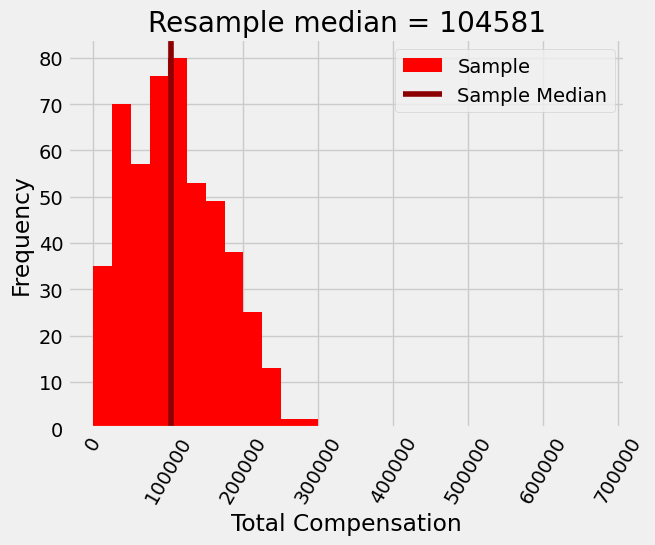

In [19]:
# draw a new sample
resample_1 = our_sample.sample(500, replace=True)

# show the sample
print(resample_1)

# plot the new sample
resample_1.plot.hist(bins=sf_bins, color = "red", label = "Sample")

# show the sample median
plt.axvline(np.median(our_sample), color = 'darkred', label = "Sample Median")

# calculate the median
resampled_median_1 = np.median(resample_1)
plt.title(f"Resample median = {int(np.round(resampled_median_1))}")

# show the legend, add x-axis labels
add_x_labels_total_compensation();

By resampling, we have something like another estimate of the population
median. By resampling again and again, we will get many such estimates, and
hence an empirical distribution of the estimates.  We can call this
distribution a *sampling distribution* of the median - it is the distribution
of the median values we get from taking many samples.  Our samples are
*bootstrap* samples, so this is the *bootstrap sampling distribution of the
median*.

In [20]:
resample_2 = our_sample.sample(500, replace=True)
resampled_median_2 = np.median(resample_2)
resampled_median_2

108738.54

## Bootstrap Empirical Distribution of the Sample Median

Let us define a function `bootstrap_median` that takes our original sample,
and the number of bootstrap samples we want to take, and returns an array of
the corresponding resampled medians.

Each time we resample and find the median, we *replicate* the bootstrap
process. So the number of bootstrap samples will be called the number of
replications.

In [21]:
def bootstrap_median(original_sample, replications):
    """Return array of bootstrapped sample medians

    Parameters
    ----------
    original_sample: Series
        Series containing the original sample
    replications: number
        number of bootstrap samples

    Returns
    -------
    samp_meds : array
        Array of bootstrapped sample medians.
    """
    # calculate the length of the original sample
    n = len(original_sample)
    
    # create an empty array to store the estimate of the medians
    # over repeated resamples
    medians = np.zeros(replications)

    # repeat the resampling procedure, and store the estimate of
    # the median each time
    for i in np.arange(replications):
        bootstrap_sample = original_sample.sample(n, replace=True)
        medians[i] = np.median(bootstrap_sample)
        
    # return the array of estimate medians
    return medians

We now replicate the bootstrap process 5,000 times. The array `bstrap_medians`
contains the medians of all 5,000 bootstrap samples. Notice that the code
takes longer to run than our previous code. It has a lot of resampling to do!

In [22]:
# run our function, to generate an array containing the bootstrapped medians
bstrap_medians = bootstrap_median(our_sample, 5000)

# show the array
bstrap_medians

array([100847.54 , 103940.84 , 108105.44 , ..., 110834.04 ,  96019.085,
       106530.56 ])

Here is the histogram of the 5000 medians. The red dot is the population
parameter: it is the median of the entire population, which we happen to know
but did not use in the bootstrap process.

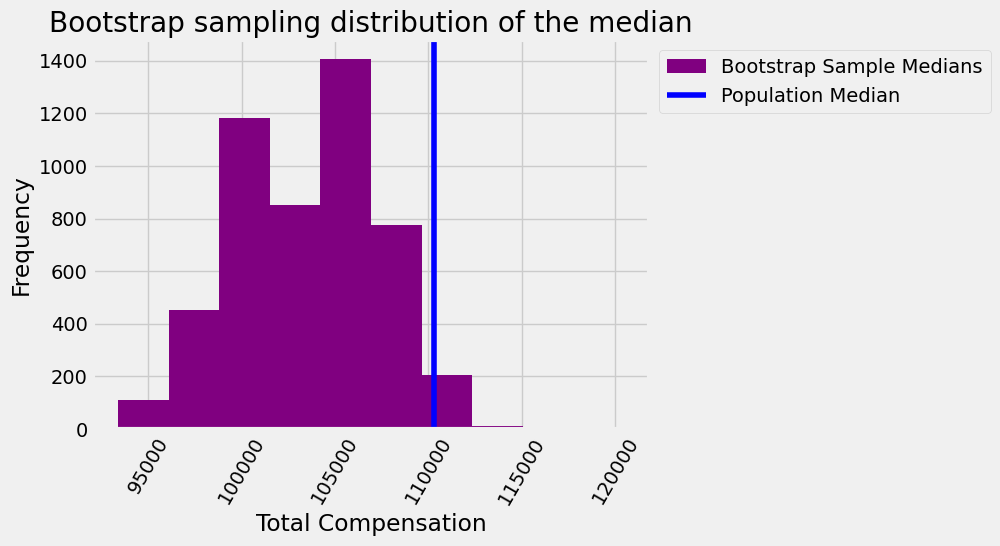

In [23]:
# a new dataframe for the medians, obtained via resampling
resampled_medians = pd.DataFrame()
resampled_medians['Bootstrap Sample Medians'] = bstrap_medians

# plot the distribution of bootstrapped medians
resampled_medians.plot.hist(color = 'purple')

# show the population median
plt.axvline(pop_median,  color='blue', label = 'Population Median')

# add title and labels to the plot
plt.title('Bootstrap sampling distribution of the median')
add_x_labels_total_compensation();

It is important to remember that the blue line is fixed: it is \\\$110,305.79, the
population median. The empirical histogram is the result of random draws, and
will be situated randomly relative to the blue line.

Remember also that the point of all these computations is to estimate the
population median, which is the blue line. Our estimates are all the randomly
generated sampled medians whose histogram you see above. We want those
estimates to contain the parameter – it they don't, then they are off.


## Do the Estimates Capture the Parameter?

How often does the empirical histogram of the resampled medians sit firmly over
the blue line, and not just brush the linewith its tails? To answer this, we must
define "sit firmly". Let's take that to mean "the middle 95% of the resampled
medians contains the red dot".

Here are the two ends of the "middle 95%" interval of resampled medians:

In [24]:
# calculate the 2.5 percentile of the bootstrapped medians
left = np.percentile(bstrap_medians, 2.5)
left

96442.71

In [25]:
# calculate the 97.5 percentile of the bootstrapped medians
right = np.percentile(bstrap_medians, 97.5)
right

110834.04000000001

In fact we can get both left and right percentiles in one call, like this:

In [26]:
# get both the percentiles in an array
np.percentile(bstrap_medians, [2.5, 97.5])

array([ 96442.71, 110834.04])

We can use unpacking in the usual way, to set our `left` and `right` variables:

In [27]:
left, right = np.percentile(bstrap_medians, [2.5, 97.5])
print('Left:', left)
print('Right:', right)

Left: 96442.71
Right: 110834.04000000001


The population median of \$110,305 is between these two numbers, `left` and
`right`. We show the interval and the population median on the histogram below.

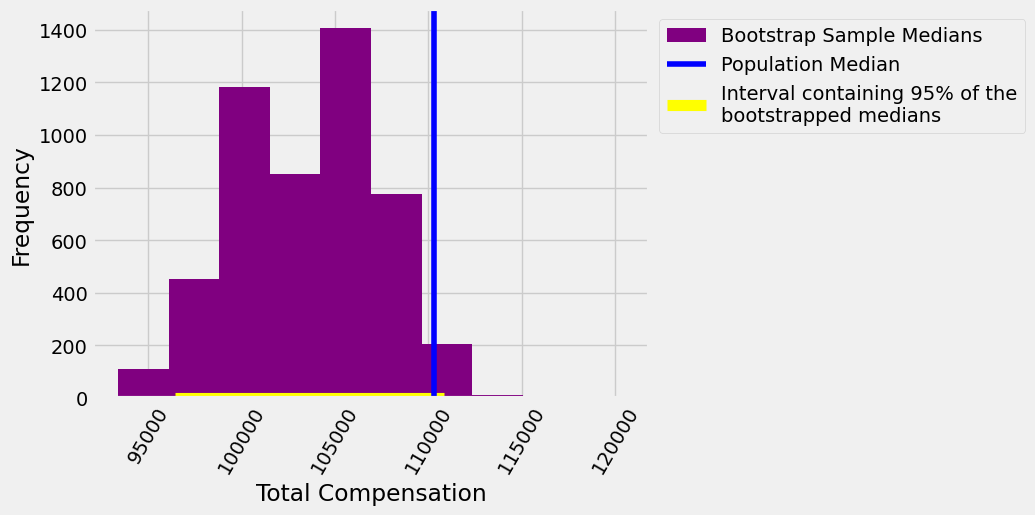

In [28]:
resampled_medians.plot.hist(color = 'purple')
plt.axvline(pop_median,  color='blue', label = 'Population Median')
plt.plot([left, right], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped medians")
add_x_labels_total_compensation();

The "middle 95%" interval of estimates captured the parameter in our example.
But was that a fluke?

To see how frequently the interval contains the parameter, we have to run the
entire process over and over again. Specifically, we will repeat the following
process 100 times:

* Draw an original sample of size 500 from the population.
* Carry out 5,000 replications of the bootstrap process and generate the
  "middle 95%" interval of resampled medians.

As usual we start by doing one trial, where we take one sample, and generate
one left and one right interval.  This is the code we have been using above.

Left 102090.47975
Left 116755.9


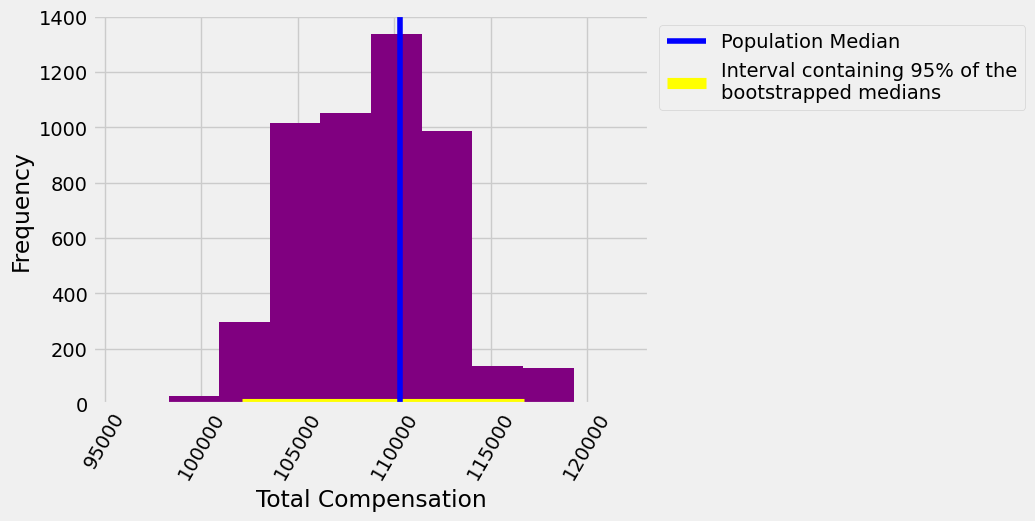

In [29]:
# One trial, generating a left and right interval.
# Take a new sample.
this_sample = compensation.sample(500, replace=True)
# Get the bootstrap sampling distribution of the median.
these_medians = pd.Series(bootstrap_median(this_sample, 5000))

these_medians.plot.hist(color = 'purple')
plt.axvline(pop_median,  color='blue', label = 'Population Median')

# Calculate the left, right ends, and plot them.
left_end, right_end = np.percentile(these_medians, [2.5, 97.5])
plt.plot([left_end, right_end], [0, 0], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped medians")

# add plot labels
add_x_labels_total_compensation();

# show the left and right end values
print('Left', left_end)
print('Left', right_end)

We will repeat this trial procedure 20 times, to give with 20 left and right
intervals, and count how many of these intervals contain the population median.

**Spoiler alert:** The statistical theory of the bootstrap says that the number
should be around 95. It may be in the low 90s or high 90s, but not much farther
off 95 than that.

In [30]:
# THE BIG SIMULATION: This one can take several minutes.

# Set up to make 20 left and right intervals
n_intervals = 20
left_ends = np.zeros(n_intervals)
right_ends = np.zeros(n_intervals)

for i in np.arange(n_intervals):
    # One trial, generating a left and right interval.
    # Take a new sample.
    this_sample = compensation.sample(500, replace=True)
    # Get the bootstrap sampling distribution of the median.
    these_medians = bootstrap_median(this_sample, 5000)
    # Calculate the left, right ends.
    left_end, right_end = np.percentile(these_medians, [2.5, 97.5])
    # Store the results for this trial.
    left_ends[i] = left_end
    right_ends[i] = right_end

# Put interval ends into own data frame.
intervals = pd.DataFrame()
intervals['Left'] = left_ends
intervals['Right'] = right_ends

For each of the 25 replications, we get one (left, right) interval of
estimates of the median.

In [31]:
intervals

,Left,Right
0,101006.370000,112553.531250
1,105246.830000,120182.230000
2,104034.405000,117110.720000
3,100941.805000,111964.651875
4,103215.170000,115071.230000
5,101164.250000,113360.790000
6,100996.984125,114183.010000
7,105445.800000,116636.355000
8,104075.730000,115374.970000
9,102331.055000,113049.270000


The good intervals are those that contain the parameter we are trying to
estimate. Typically the parameter is unknown, but in this section we happen to
know what the parameter is.

In [32]:
pop_median

110305.79

How many of the 20 intervals contain the population median? That's the number
of intervals where the left end is below the population median and the right
end is above.

In [33]:
intervals["Contains Population Median"] = np.logical_and(left_ends < pop_median, right_ends > pop_median)
intervals

,Left,Right,Contains Population Median
0,101006.370000,112553.531250,True
1,105246.830000,120182.230000,True
2,104034.405000,117110.720000,True
3,100941.805000,111964.651875,True
4,103215.170000,115071.230000,True
5,101164.250000,113360.790000,True
6,100996.984125,114183.010000,True
7,105445.800000,116636.355000,True
8,104075.730000,115374.970000,True
9,102331.055000,113049.270000,True


It takes a few minutes to construct all the intervals, but try it again if you
have the patience. Most likely, about 95% intervals will be good
ones: they will contain the parameter.

It's hard to show you all the intervals on the horizontal axis as they have
large overlaps – after all, they are all trying to estimate the same parameter.
The graphic below shows each interval on the same axes by stacking them
vertically. The vertical axis is simply the number of the replication from
which the interval was generated.

The red line is where the parameter is. Good intervals cover the parameter;
there are about 95 of these, typically.

If an interval doesn't cover the parameter, it's a dud. The duds are the ones
where you can see "daylight" around the red line. There are very few of them –
about 5, typically – but they do happen.

Any method based on sampling has the possibility of being off. The beauty of
methods based on random sampling is that we can quantify how often they are
likely to be off.

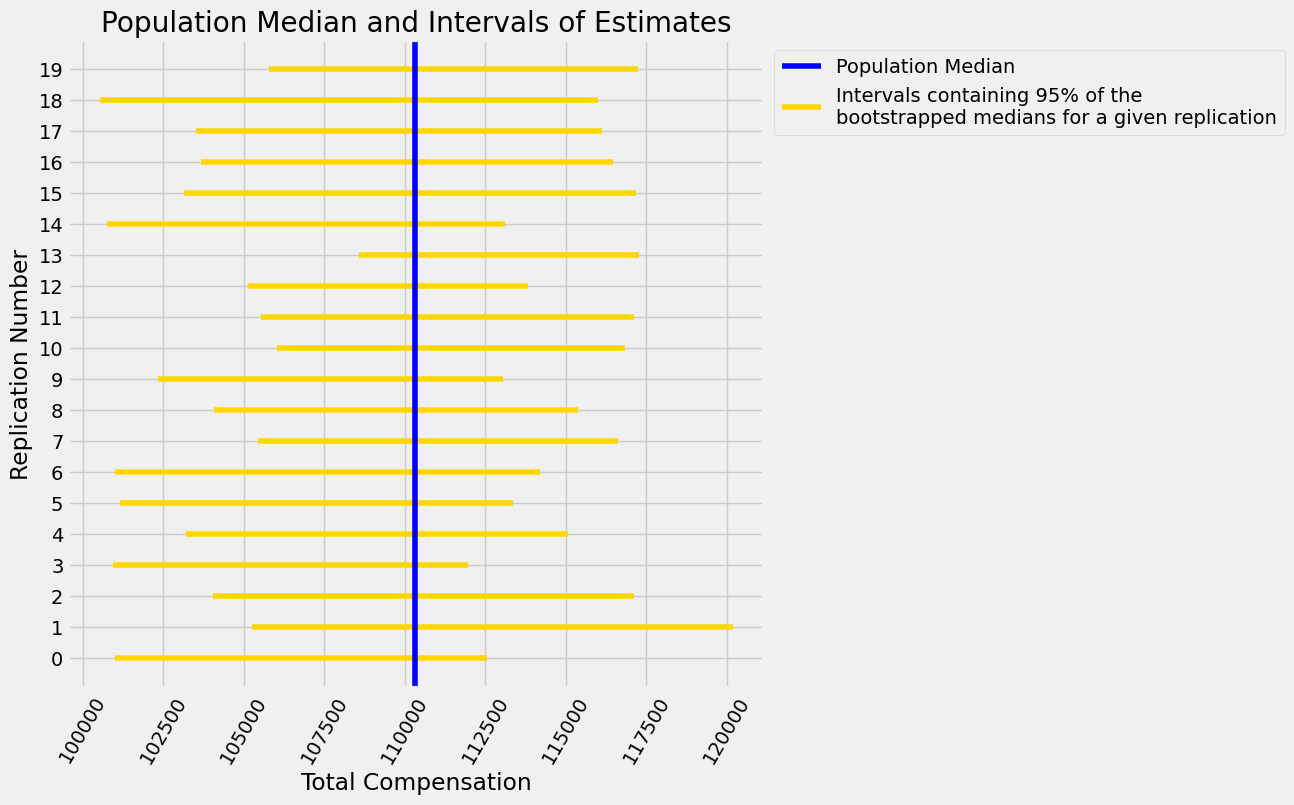

In [34]:
plt.figure(figsize=(8,8))
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold')
plt.axvline(pop_median,  color='blue', label = 'Population Median')
plt.plot([], [], color = 'gold',
         label = "Intervals containing 95% of the\nbootstrapped medians for a given replication")
plt.ylabel('Replication Number')
plt.yticks(np.arange(n_intervals))
plt.title('Population Median and Intervals of Estimates')
add_x_labels_total_compensation();

To summarize what the simulation shows, suppose you are estimating the
population median by the following process:

* Draw a large random sample from the population.
* Bootstrap your random sample and get an estimate from the new random sample.
* Repeat the above step thousands of times, and get thousands of estimates.
* Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. Now if you repeat **the entire
process** 20 times, ending up with 20 intervals, then about 95% of those 20
intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of
the time.

You can replace 95% by a different value, as long as it's not 100. Suppose you
replace 95% by 80% and keep the sample size fixed at 500. Then your intervals
of estimates will be shorter than those we simulated here, because the "middle
80%" is a smaller range than the "middle 95%". Only about 80% of your intervals
will contain the parameter.

# Back to The Fundamental Problem of Data Science

Remember our data scientists predicament? 

[common misinterpretations - the confidence level refers to the *method* of constructing
the intervals, but is commonly misinterpretted as referring to the the interval itself]

> This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).